In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [63]:
#Import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [4]:
# Calculate Regression metrices RMSE, RRMSE and R2
def reg_model_metrics(actual, pred):
    MSE = mean_squared_error(actual, pred)
    RMSE = np.sqrt(MSE)
    actual_mean = np.mean(actual)
    RRMSE = 100 * RMSE / actual_mean
    R2 = r2_score(actual, pred)
    return RMSE, RRMSE, R2

# Display prediction resutls using 1:1 scatter plot
def scatter_plot(actual, pred, title):
    RMSE, RRMSE, R2 = reg_model_metrics(actual, pred)
    fig,ax = plt.subplots()
    ax.scatter(actual, pred, edgecolors=(0,0,0))
    ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', lw=2)
    text = r"R2 = %.2f" % (R2);text += "\n"; text += r"RMSE = %.2f" % (RMSE); text += "\n"
    text += r"RRMSE = %.2f" % (RRMSE) +'%'
    plt.annotate(text, xy=(0.05, 0.85), xycoords='axes fraction',color='black', fontsize=10,
                 bbox=dict(facecolor='none',edgecolor='red'))
    ax.set_xlabel('Measured Yield (kg/ha)')
    ax.set_ylabel('Predicted Yield (kg/ha) ')
    ax.set_title(title)
    plt.show()

In [5]:
# Read the data
df = pd.read_excel('/content/drive/MyDrive/ML/Week_10/data.xlsx', header=1)

# Get different features
y = np.asarray(df.iloc[1:,1])
x_sp = df.iloc[1:,2:23] # spectral features

# Data preprocessing and training and testing sets spliting
x = x_sp # select the input features used as independent variables
test_size = 0.3
random_state=1

# Training and testing sets spliting
(X_train, X_test, y_train, y_test) = train_test_split(x, y, test_size=test_size, random_state=random_state)

In [7]:
# Define the model
model = SVR()


#Pipeline 1: SelectKBest Feature Selection & Pipeline 2: PCA Feature Selection

In [73]:
# Build the first pipeline with SelectKBest and SVR as the estimator
pipe_1 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('feature_selection', SelectKBest(f_regression)),
    ('model', SVR())
])

# Build the second pipeline with PCA and SVR as the estimator
pipe_2 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('feature_selection', PCA()),
    ('model', SVR())
])


In [76]:
# Parameters for pipeline 1
pipe_1_param = {
    'feature_selection__k': [1, 5, 10],
    'model__C': [0.01, 0.1, 1, 10, 100, 1000],
    'model__gamma': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
    'model__kernel': ['rbf', 'linear']
}

# Parameters for pipeline 2
pipe_2_param = {
    'feature_selection__n_components': [1, 5, 10],
    'model__C': [0.01, 0.1, 1, 10, 100, 1000],
    'model__gamma': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
    'model__kernel': ['rbf', 'linear']
}

In [77]:
%%time
# Cross-validation for hyperparameter tuning and feature selection for Pipeline 1
grid_model_1 = GridSearchCV(pipe_1, pipe_1_param, verbose=3, n_jobs=-1)

# Fit the model to the training set data using the best model parameters for Pipeline 1
grid_result_1 = grid_model_1.fit(X_train, y_train)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
CPU times: user 1.63 s, sys: 143 ms, total: 1.78 s
Wall time: 30.2 s


In [78]:
# Get the best model for Pipeline 1
best_model_1 = grid_result_1.best_estimator_

In [79]:
%%time
# Cross-validation for hyperparameter tuning and feature selection for Pipeline 2
grid_model_2 = GridSearchCV(pipe_2, pipe_2_param, verbose=3, n_jobs=-1)

# Fit the model to the training set data using the best model parameters for Pipeline 2
grid_result_2 = grid_model_2.fit(X_train, y_train)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
CPU times: user 1.77 s, sys: 125 ms, total: 1.89 s
Wall time: 32.6 s


In [85]:
# Now look at the best parameters
grid_model_1.best_params_

{'feature_selection__k': 10,
 'model__C': 1000,
 'model__gamma': 10,
 'model__kernel': 'rbf'}

In [80]:
# Get the best model for Pipeline 2
best_model_2 = grid_result_2.best_estimator_

# Training Results for Pipeline 2
y_pred_train_2 = best_model_2.predict

In [84]:
# Now look at the best parameters
grid_model_2.best_params_

{'feature_selection__n_components': 10,
 'model__C': 1000,
 'model__gamma': 1,
 'model__kernel': 'rbf'}

#Comparison the results from the two pipelines

In [81]:
# Evaluate and print results for Pipeline 1
y_pred_train_1 = best_model_1.predict(X_train)
RMSE_train_1, RRMSE_train_1, R2_train_1 = reg_model_metrics(y_train, y_pred_train_1)

y_pred_test_1 = best_model_1.predict(X_test)
RMSE_test_1, RRMSE_test_1, R2_test_1 = reg_model_metrics(y_test, y_pred_test_1)

print("Results for Pipeline 1:")
print("Pipeline 1 Training R^2: %.2f" % R2_train_1)
print("Pipeline 1 Training RMSE: %.2f" % RMSE_train_1)
print("Pipeline 1 Training RRMSE: %.2f" % RRMSE_train_1 + "%")
print("Pipeline 1 Testing R^2: %.2f" % R2_test_1)
print("Pipeline 1 Testing RMSE: %.2f" % RMSE_test_1)
print("Pipeline 1 Testing RRMSE: %.2f" % RRMSE_test_1 + "%")


# Evaluate and print results for model 1
y_pred_train_2 = best_model_2.predict(X_train)
RMSE_train_2, RRMSE_train_2, R2_train_1 = reg_model_metrics(y_train, y_pred_train_2)

y_pred_test_2 = best_model_2.predict(X_test)
RMSE_test_2, RRMSE_test_2, R2_test_2 = reg_model_metrics(y_test, y_pred_test_2)

print("\n\nResults for Pipeline 2:")
print("Pipeline 2 Training R^2: %.2f" % R2_train_2)
print("Pipeline 2 Training RMSE: %.2f" % RMSE_train_2)
print("Pipeline 2 Training RRMSE: %.2f" % RRMSE_train_2 + "%")
print("Pipeline 2 Testing R^2: %.2f" % R2_test_2)
print("Pipeline 2 Testing RMSE: %.2f" % RMSE_test_2)
print("Pipeline 2 Testing RRMSE: %.2f" % RRMSE_test_2 + "%")






Results for Pipeline 1:
Pipeline 1 Training R^2: 0.57
Pipeline 1 Training RMSE: 594.29
Pipeline 1 Training RRMSE: 19.80%
Pipeline 1 Testing R^2: 0.45
Pipeline 1 Testing RMSE: 672.64
Pipeline 1 Testing RRMSE: 22.37%


Results for Pipeline 2:
Pipeline 2 Training R^2: 0.56
Pipeline 2 Training RMSE: 600.66
Pipeline 2 Training RRMSE: 20.01%
Pipeline 2 Testing R^2: 0.49
Pipeline 2 Testing RMSE: 646.14
Pipeline 2 Testing RRMSE: 21.49%


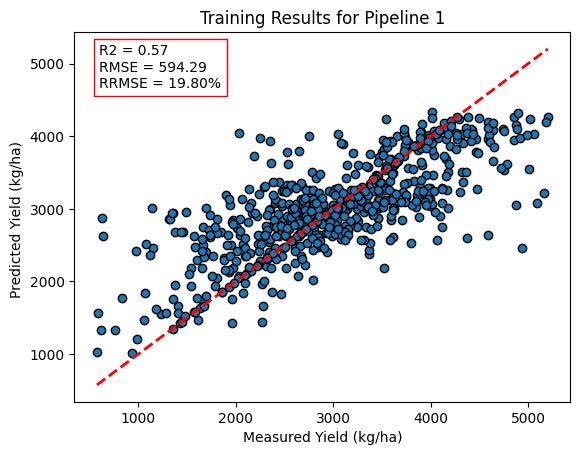

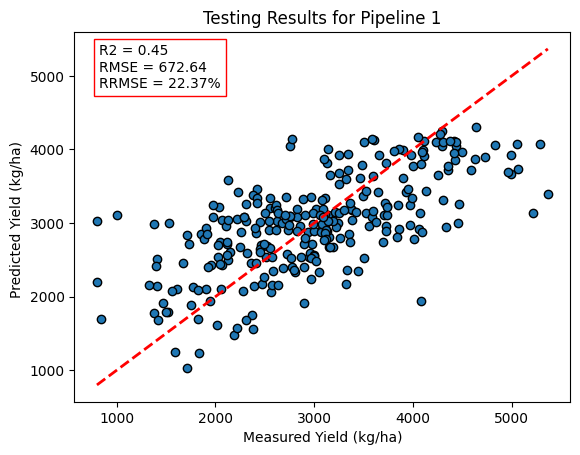

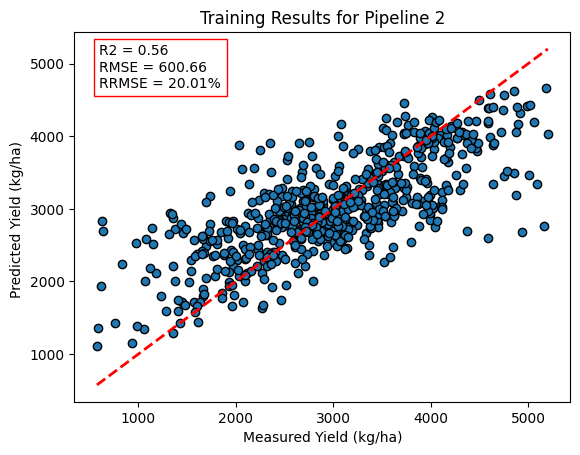

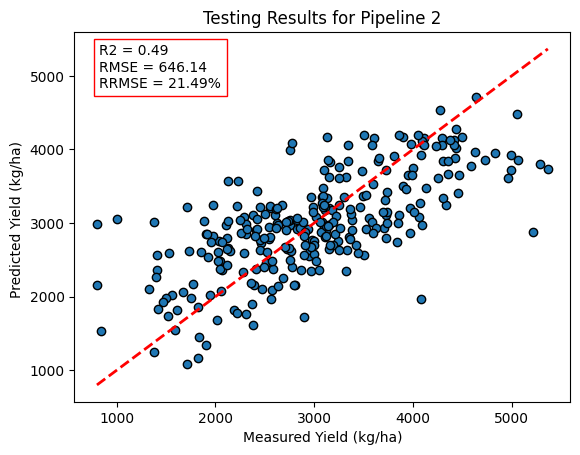

In [82]:
# Visualize the training result for Pipeline 1
title = 'Training Results for Pipeline 1'
scatter_plot(y_train, y_pred_train_1, title)

# Visualize the testing result for Pipeline 1
title = 'Testing Results for Pipeline 1'
scatter_plot(y_test, y_pred_test_1, title)

# Visualize the training result for Pipeline 2
title = 'Training Results for Pipeline 2'
scatter_plot(y_train, y_pred_train_2, title)

# Visualize the testing result for Pipeline 2
title = 'Testing Results for Pipeline 2'
scatter_plot(y_test, y_pred_test_2, title)


#Conclusion

I built two pipelines one with a difference of the feature selection methods i.e Pipeline 1: SelectKBest and Pipeline 2: PCA.
Among the two pipelines, I would rate the second pipeline to be a better performing model as the Test R-squared and Test RRMSE values are slightly better for Pipeline 2 than that of Pipeline 1.

The best hyperparamters for Pipeline 2 are:
k : 10, C : 1000, gamma: 10, kernel: rbf

Whereas, the best parameters for Pipeline 1 are:
k : 10, C : 1000, gamma: 1, kernel: rbf